In [64]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as pl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
# Import product from tqdm
from itertools import product
from tqdm.contrib.itertools import product as tqdm_product
from collections import defaultdict

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Format the AnnData object

## Basic modifications

In [65]:
# File is in the shared drive
# https://drive.google.com/file/d/1FLSDaiZ3DvNv4Z4yRzjPEKpmK2CkULkf/view?usp=drive_link
adata = sc.read_h5ad("../scrnaseq/run/star_plate/star/mtx_conversions/combined_raw_matrix.h5ad")

# nf-core/scrnaseq adds these columns to the obs dataframe, but they are not useful for us
adata.obs = adata.obs.drop(columns=["fastq_1", "fastq_2"])

# Add column for sample type
adata.obs["sample"] = adata.obs["sample"].str.replace("_raw", "")
adata.obs["sample_type"] = adata.obs["sample"].map(lambda x: "rr_incl" if "RR" in x else "combined" if x.startswith("combined") else "rr_depl")

# Extract the barcode from the cell name
adata.obs["barcode"] = adata.obs.index.str.split("_").str[0]

# Convert the count matrix to int32
adata.layers["count"] = adata.layers["count"].astype("int32")
adata.X = adata.layers["count"]

# By default, the var names are the gene IDs
# Gene names are generally easier to interpret, so we will use the gene names as the var names
# In some cases this will result in duplicate var names, but here this is not a problem
adata.var_names = adata.var["gene_symbol"].str.upper()

# Saving the anndata object fails if the index name also exists as a column
adata.var.index.name = "gene_name"

adata

AnnData object with n_obs × n_vars = 14592 × 79623
    obs: 'sample', 'sample_type', 'barcode'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

## Identify the cell types

We were provided with a mapping from the cell position to the cell type.
Thus, we first need to map the barcodes to the positions in the matrix and then map the positions to the cell types.

In [66]:
df_bc_pos = pd.read_csv("../data/reference/plate_position.tsv", sep="\t", index_col=1)
bc_pos = df_bc_pos.to_dict()["Position"]

adata.obs["well_position"] = adata.obs["barcode"].map(bc_pos)

# well_position looks like "A11"
adata.obs["well_row"] = adata.obs["well_position"].str[0]
adata.obs["well_column"] = adata.obs["well_position"].str[1:].astype(int)

# Columns 0-11 are 2CLC, columns 12-23 are mESC
adata.obs["cell_type"] = adata.obs["well_column"].apply(lambda x: "mESC" if x > 11 else "2CLC")
adata.obs["cell_type"][adata.obs["sample"].isin(["24L007783_S5_L001", "24L007783_S5_L002"])] = "2CLC"
adata.obs["cell_type"][adata.obs["sample"].isin(["24L007784_S6_L001", "24L007784_S6_L002"])] = "mESC"


/var/folders/fn/l7sbwldd3ll8jjsyrdbqymxr0000gn/T/ipykernel_16888/3395290471.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["cell_type"][adata.obs["sample"].isin(["24L007783_S5_L001", "24L007783_S5_L002"])] = "2CLC"
/var/folders/fn/l7sbwldd3ll8jjsyrdbqymxr0000gn/T/ipykernel_16888/3395290471.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["cell_type"][adata.obs["sample"].isin(["24L007784_S6_L001", "24L007784_S6_L002"])] = "mESC"


In [67]:
df_gtf = pd.read_csv("../data/reference/mouse/modified.gtf", sep="\t", comment="#", header=None)
df_gtf.columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
df_gtf = df_gtf[df_gtf["feature"] == "transcript"]
df_gtf['attribute'] = df_gtf['attribute'].apply(lambda row: dict([[value.strip(r'"') for value in entry.strip().split(' ', 1)] for entry in row.split(';') if entry]))
df_gtf["gene_id"] = df_gtf["attribute"].apply(lambda x: x["gene_id"])
df_gtf["gene_name"] = df_gtf["attribute"].apply(lambda x: x["gene_name"])
df_gtf["gene_type"] = df_gtf["attribute"].apply(lambda x: x["gene_type"])
df_gtf = df_gtf[["gene_id", "gene_name", "gene_type"]]
df_gtf.index = df_gtf["gene_id"]
df_gtf = df_gtf[~df_gtf.index.duplicated(keep='first')]
df_gtf.drop(columns="gene_id", inplace=True)
adata.var["gene_type"] = adata.var["gene_ids"].map(df_gtf["gene_type"]).fillna("transposable_element")
adata.var["gene_type"].value_counts()

gene_type
lncRNA                                32957
protein_coding                        21749
processed_pseudogene                   9329
TEC                                    3220
miRNA                                  2206
unprocessed_pseudogene                 2158
snoRNA                                 1507
snRNA                                  1381
transposable_element                   1226
transcribed_unprocessed_pseudogene      995
transcribed_processed_pseudogene        949
misc_RNA                                562
rRNA                                    360
IG_V_gene                               218
IG_V_pseudogene                         158
TR_V_gene                               144
ERCC-spike-in                            92
TR_J_gene                                70
transcribed_unitary_pseudogene           67
unitary_pseudogene                       59
scaRNA                                   51
TR_V_pseudogene                          34
ribozyme              

In [68]:
adata.raw = adata.copy()

# Quality control

In [69]:
# All human mitochondrial genes start with "mt-"
adata.var["mt"] = adata.var["gene_symbol"].str.startswith("mt-")
adata.var["rRNA"] = adata.var["gene_type"] == "rRNA"
adata.var["lncRNA"] = adata.var["gene_type"] == "lncRNA"

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "rRNA", "lncRNA"], inplace=True, log1p=True, layer="count"
)

In [70]:
# Empty wells
adata = adata[~adata.obs.index.isin(['ACGTTGTA_24L007780_S2_L002_raw', 'GGATGATG_2CLCmesc_6_RR_S14_raw', 'GTGATGTC_2CLCmesc_6_RR_S14_raw'])].copy()

In [71]:
sc.pp.scrublet(adata, batch_key="sample")
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    11989
True      2600
Name: count, dtype: int64

## Raw QC plots

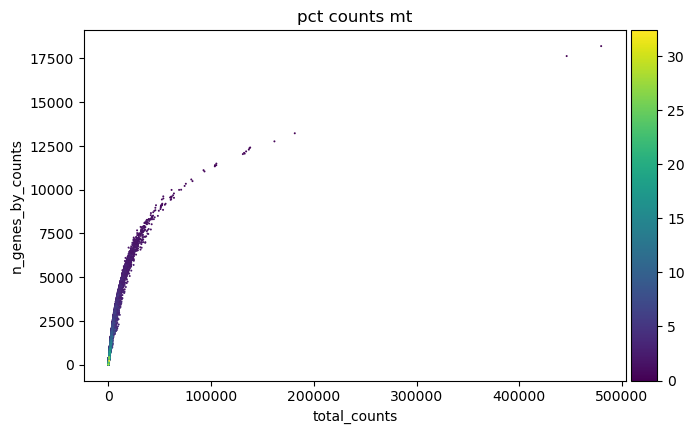

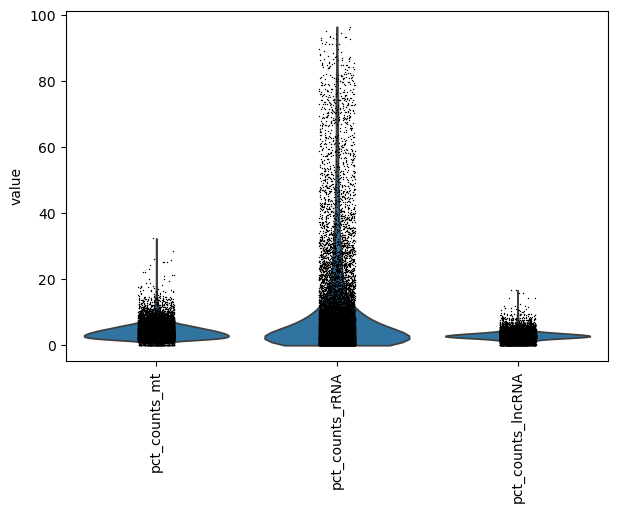

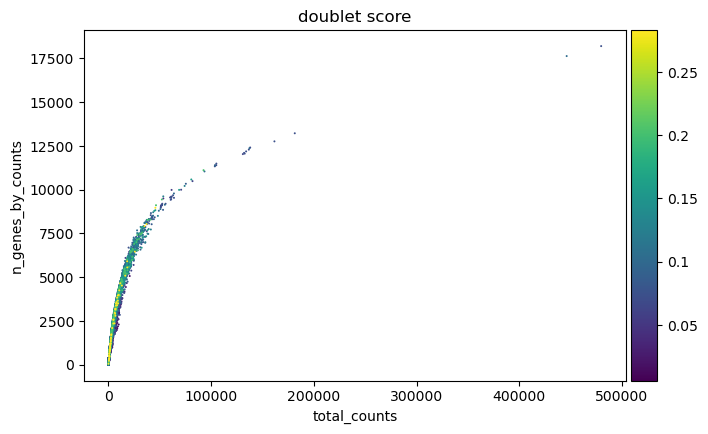

In [72]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, ["pct_counts_mt", "pct_counts_rRNA", "pct_counts_lncRNA"], rotation=90)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

# Well-position heatmaps

In [74]:
metrics = ["n_genes_by_counts", "log1p_n_genes_by_counts", "log1p_total_counts", "total_counts", "pct_counts_mt", "doublet_score"]
outdir = "figures/qc"
os.makedirs(outdir, exist_ok=True)

for sample, metric in tqdm_product(adata.obs["sample"].unique(), metrics + ["pct_counts_rRNA", "pct_counts_lncRNA"]):
    metric_dir = f"{outdir}/{metric}"
    os.makedirs(metric_dir, exist_ok=True)

    sample_data = adata[adata.obs["sample"] == sample, :].copy() #collect the data only for 1 sample
    heatmap_data = sample_data.obs.pivot_table(
        index='well_row',
        columns='well_column',
        values=metric
        )
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': metric})
    plt.title(sample)
    plt.xlabel("Well Column")
    plt.ylabel("Well Row")
    plt.tight_layout()
    
    plt.savefig(f"{metric_dir}/{sample}.png")
    plt.close()

100%|██████████| 304/304 [01:03<00:00,  4.81it/s]


# Overlap between matched samples

In [75]:
sample_matching = pd.read_csv(
    "../data/reference/sample_matching.tsv",
    sep="\t",
    header=None,
    dtype=str
)
sample_matching.columns = ["sample_group", "rr_depl", "rr_incl", "combined", "facs_day"]
sample_matching = sample_matching.melt(value_vars=["rr_depl", "rr_incl", "combined"], id_vars=["sample_group", "facs_day"])
sample_matching.index = sample_matching["value"]
sample_matching.drop(columns=["value", "variable"], inplace=True)

sample_group = sample_matching["sample_group"].to_dict()
sample_facs_day = sample_matching["facs_day"].map({"1": "A", "2": "B"}).to_dict()

In [76]:
adata.obs["sample_group"] = adata.obs["sample"].map(sample_group).astype("category")
adata.obs["facs_day"] = adata.obs["sample"].map(sample_facs_day)
adata.obs["sample_group"].value_counts()

sample_group
003    768
004    768
1      768
2      768
3      768
4      768
5      768
6      766
Name: count, dtype: int64

In [78]:
adata_matched = adata[adata.obs["sample_group"].notnull()].copy()
match_types = adata_matched.obs["sample_type"].unique()
metrics_smaller_better = ["pct_counts_mt", "doublet_score"]

for metric, type1, type2 in tqdm_product(metrics, match_types, match_types):
    if type1 == type2 or type1 < type2:
        continue

    smaller_better = metric in metrics_smaller_better
    os.makedirs(f"{outdir}/jaccard/{metric}", exist_ok=True)

    obs_type1 = adata_matched.obs.loc[adata_matched.obs["sample_type"] == type1, [metric, "well_position", "sample_group"]]
    obs_type2 = adata_matched.obs.loc[adata_matched.obs["sample_type"] == type2, [metric, "well_position", "sample_group"]]

    thresholds_jaccard = defaultdict(lambda: defaultdict(float))

    for type1_threshold, type2_threshold in product(
        np.linspace(obs_type1[metric].min(), obs_type1[metric].max(), 15), 
        np.linspace(obs_type2[metric].min(), obs_type2[metric].max(), 15)
        ):
        type1_pass = obs_type1[obs_type1[metric] > type1_threshold] if smaller_better else obs_type1[obs_type1[metric] < type1_threshold]
        type2_pass = obs_type2[obs_type2[metric] > type2_threshold] if smaller_better else obs_type2[obs_type2[metric] < type2_threshold]

        type1_set = set(zip(type1_pass["well_position"], type1_pass["sample_group"]))
        type2_set = set(zip(type2_pass["well_position"], type2_pass["sample_group"]))

        union_size = len(type1_set.union(type2_set))
        jaccard = len(type1_set.intersection(type2_set)) / union_size if union_size > 0 else np.nan
        thresholds_jaccard[type1_threshold][type2_threshold] = jaccard

    df_jaccard = pd.DataFrame(thresholds_jaccard)
    sns.heatmap(df_jaccard, cmap="viridis", annot=False, cbar_kws={'label': "Jaccard Index"})
    plt.xlabel(f"{type2}")
    plt.ylabel(f"{type1}")
    plt.title(f"Jaccard Index for {metric}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/jaccard/{metric}/{type1}_{type2}.png")
    plt.close()

100%|██████████| 54/54 [00:07<00:00,  7.03it/s]


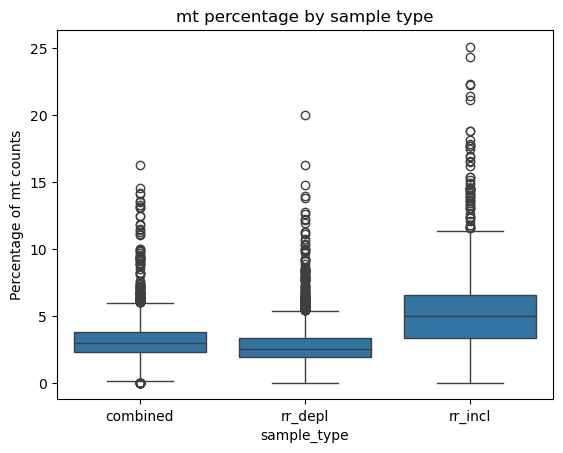

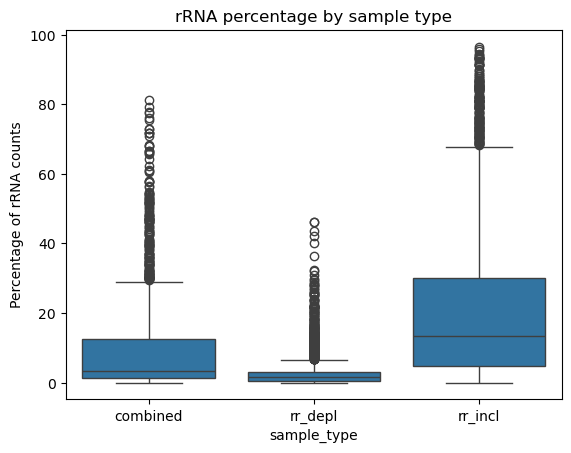

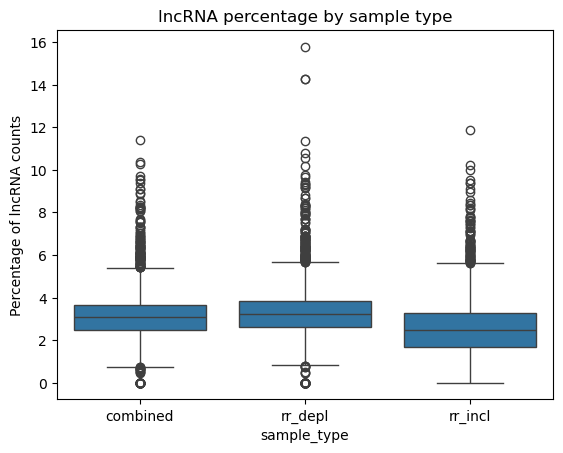

In [79]:
df_matched = adata_matched.obs.copy()
for metric in ["mt", "rRNA", "lncRNA"]:
    sns.boxplot(data=df_matched, x="sample_type", y=f"pct_counts_{metric}")
    plt.ylabel(f"Percentage of {metric} counts")
    plt.title(f"{metric} percentage by sample type")
    plt.show()
    plt.close()

# Visualization of expression in the samples

In [80]:
well_columns = np.sort(adata.obs["well_column"].unique())
well_rows = np.sort(adata.obs["well_row"].unique())
adata_type = ["combined","rr_depl","rr_incl"]

In [116]:
gene_list = ["ZSCAN4A", "ZSCAN4B", "ZSCAN4C", "ZSCAN4D", "ZSCAN4E", "ZSCAN4F", "GFPT1", "GFPT2", "DUXF3", "ZFP352", "EIF1AD10", "SOX2", "NANOG", "MERVL-INT:TE", "MERVL_2A-INT:TE", "TBGFP"]

for type, gene in tqdm_product(adata_type, gene_list):
    os.makedirs(f"{outdir}/genes/{gene}", exist_ok=True)

    adata_gene = adata_matched[adata_matched.obs["sample_type"] == type,:].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_gene.obs["well_position"].unique():

        well_position_mask = adata_gene.obs["well_position"] == well
        well_column_mask = adata_gene.var_names == gene

        row_indices = np.where(well_position_mask)[0]
        col_indices = np.where(well_column_mask)[0]

        gene_values = adata_gene.X[row_indices, col_indices].flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"{gene} expression: {type}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/{gene}/{type}_{gene}.png")
    plt.close()

100%|██████████| 48/48 [01:17<00:00,  1.62s/it]


In [136]:
for type in adata_type:
    os.makedirs(f"{outdir}/genes/ERCC-SPIKE-IN", exist_ok=True)

    adata_gene = adata_matched[adata_matched.obs["sample_type"] == type,adata_matched.var["gene_type"] == "ERCC-spike-in"].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_gene.obs["well_position"].unique():

        well_position_mask = adata_gene.obs["well_position"] == well
        #well_column_mask = adata_gene.var["gene_type"] == "ERCC-spike-in"

        row_indices = np.where(well_position_mask)[0]
        #col_indices = np.where(well_column_mask)[0]

        gene_values = adata_gene.X[row_indices, :].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"ERCC-SPIKE-IN expression: {type}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/ERCC-SPIKE-IN/{type}_ERCC-SPIKE-IN.png")
    plt.close()

In [81]:
for type, sample in tqdm_product(adata_type, adata.obs["sample"].unique()):
    os.makedirs(f"{outdir}/genes/{type}", exist_ok=True)

    adata_samp = adata_matched[adata_matched.obs["sample_type"] == type,:]
    adata_diff = adata_samp[adata_samp.obs["sample"] == sample, :]
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_diff.obs["well_position"].unique():

        well_position_mask = adata_diff.obs["well_position"] == well

        row_indices = np.where(well_position_mask)[0]

        gene_values = adata_diff.X[row_indices,:].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"Gene expression:{type}_{sample}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/{type}/{sample}.png")
    plt.close()

100%|██████████| 114/114 [00:29<00:00,  3.82it/s]


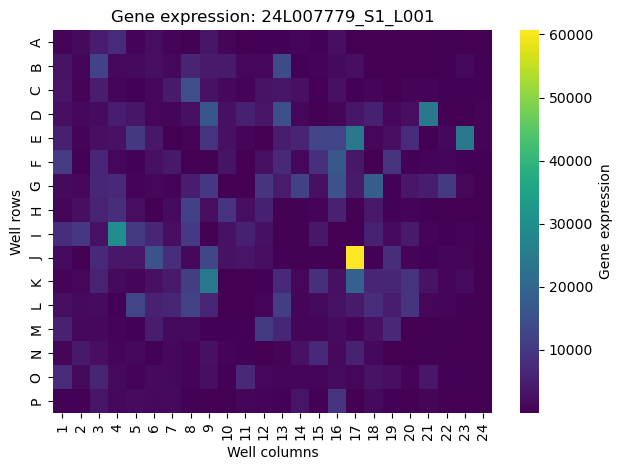

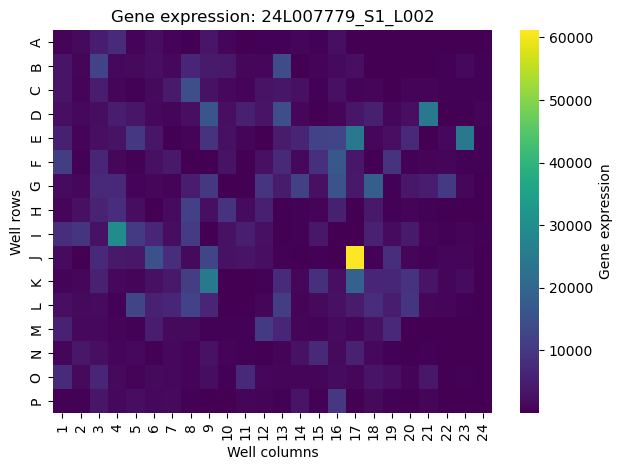

In [99]:
samples = ["24L007779_S1_L001", "24L007779_S1_L002"]

for sample in samples:

    adata_diff = adata[adata.obs["sample"] == sample,:].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_diff.obs["well_position"].unique():

        well_position_mask = adata_diff.obs["well_position"] == well

        row_indices = np.where(well_position_mask)[0]

        gene_values = adata_diff.X[row_indices,:].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"Gene expression: {sample}")
    plt.tight_layout()
    plt.show()

In [36]:
samples = ["24L007779_S1_L001", "24L007779_S1_L002", "24L007781_S3_L001", "24L007781_S3_L002", "24L007783_S5_L001", "24L007783_S5_L002", "24L007784_S6_L001", "24L007784_S6_L002"]
gene_dfs = {}

for sample in samples:

    adata_diff = adata[adata.obs["sample"] == sample,:].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_diff.obs["well_position"].unique():

        well_position_mask = adata_diff.obs["well_position"] == well

        row_indices = np.where(well_position_mask)[0]

        gene_values = adata_diff.X[row_indices,:].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    gene_dfs[sample] = pd.DataFrame(MinMaxScaler().fit_transform(gene_df),
                                    index=gene_df.index, 
                                    columns=gene_df.columns)


In [83]:
len(samples)

8

In [84]:
x = 0
distances = {}
while x < len(samples)-1:
    sample_1= samples[x]
    sample_2 = samples[x+1]
    distances[f"{sample_1}_{sample_2}"] = np.array([cosine(np.array(gene_dfs[sample_1])[:,i], np.array(gene_dfs[sample_2])[:,i]) for i in range(gene_dfs[sample_1].shape[1])])
    distances[f"{sample_1}_{sample_2}"] = np.sum(distances[f"{sample_1}_{sample_2}"])/gene_dfs[sample_1].shape[1]
    x= x+2

distances

{'24L007779_S1_L001_24L007779_S1_L002': np.float64(0.0001237106967773479),
 '24L007781_S3_L001_24L007781_S3_L002': np.float64(0.0001347393576517595),
 '24L007783_S5_L001_24L007783_S5_L002': np.float64(0.00032287629121731387),
 '24L007784_S6_L001_24L007784_S6_L002': np.float64(0.00026157914771669327)}

## Filtering

Thresholds were estimated based on the raw QC plots.
Can be adjusted if needed.

<Axes: title={'center': 'Histogram of log1p total counts for rRNA genes'}, ylabel='Frequency'>

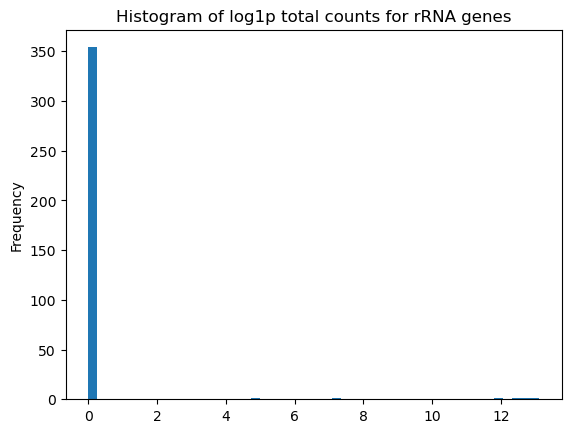

In [117]:
adata_rrna = adata[:, adata.var["gene_type"] == "rRNA"].copy()
adata_rrna.var["log1p_total_counts"].plot.hist(bins=50, title="Histogram of log1p total counts for rRNA genes")

In [118]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var["gene_type"].value_counts()

gene_type
protein_coding                        16237
lncRNA                                 8668
processed_pseudogene                   1897
TEC                                    1520
transposable_element                   1020
transcribed_processed_pseudogene        163
unprocessed_pseudogene                  123
snoRNA                                   80
ERCC-spike-in                            68
transcribed_unprocessed_pseudogene       52
misc_RNA                                 51
snRNA                                    35
scaRNA                                   13
rRNA                                      6
transcribed_unitary_pseudogene            6
unitary_pseudogene                        5
ribozyme                                  4
IG_V_gene                                 4
TR_V_gene                                 3
Mt_rRNA                                   2
miRNA                                     2
TR_C_gene                                 2
IG_C_gene             

In [119]:
adata.n_obs

11517

In [120]:
adata = adata[adata.obs["pct_counts_mt"] < 12, :].copy()
adata.n_obs

14406

In [121]:
adata = adata[adata.obs["n_genes_by_counts"] > 200, :].copy()
adata.n_obs

11615

In [122]:
#filtering doublets withdifferent threshold for RR and non-RR
adata = adata[adata.obs["doublet_score"] < 0.17, :].copy()
adata.n_obs

11332

In [123]:
#filtering wrong columns and wells
adata = adata[adata.obs["well_column"] != 24]
adata = adata[~adata.obs["well_position"].isin(["P22", "P23"]),:]
adata.n_obs

10876

## Filtered QC plots

/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


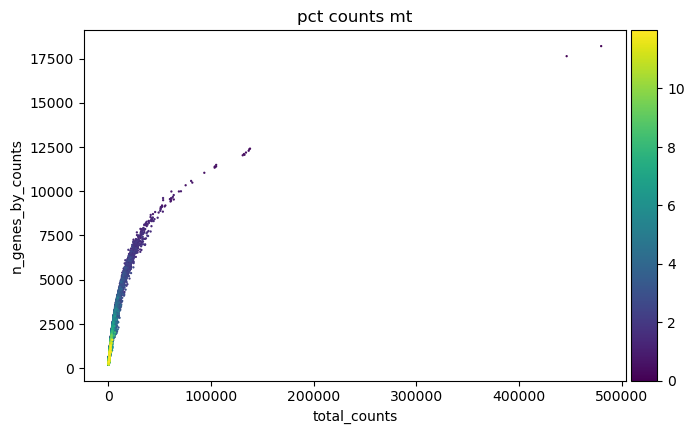

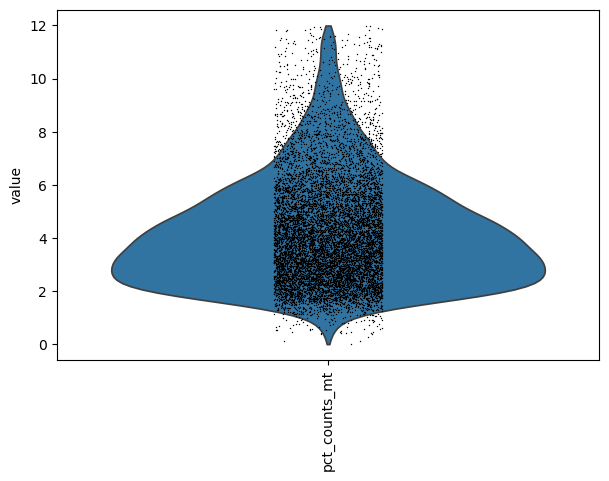

In [124]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

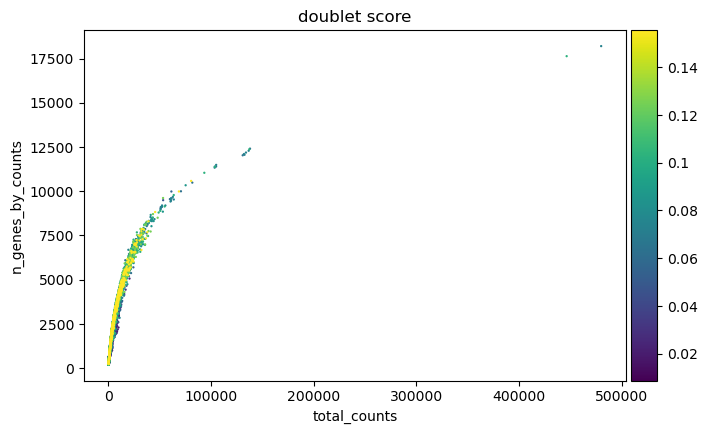

In [125]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

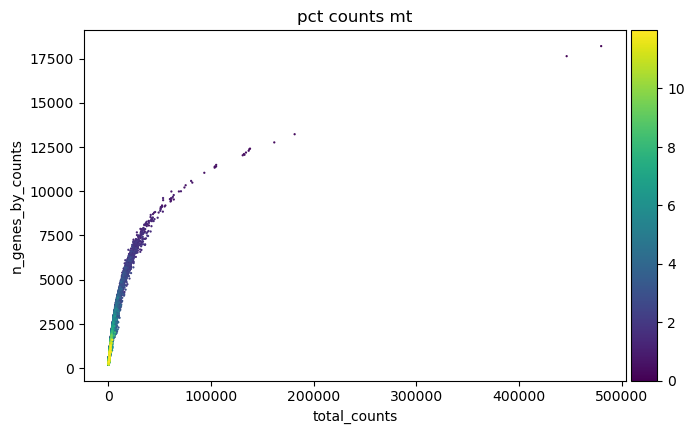

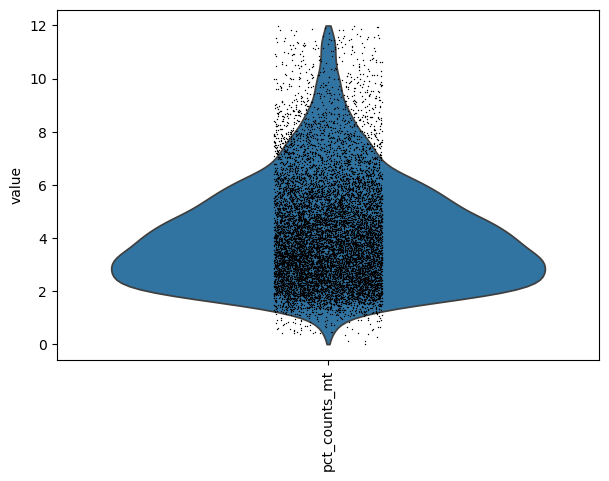

In [70]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

# Normalization

These steps update adata.X

In [126]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Finalize and save

In [127]:
# Make a copy of the log-transformed data
# It is always good to store alternative representations of count data with explicit names
# It is easy to forget what adata.X contains at a later point
adata.layers["log1p"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 10876 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced', 'log1p'

In [128]:
adata.write_h5ad("1_qc.h5ad")